In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Set seed for reproducibility
tf.random.set_seed(42)
# Define image size and batch size
IMG_SIZE = (128, 128)  # You can adjust this based on your dataset
BATCH_SIZE = 32


In [22]:
# Set paths to your dataset (make sure you update this with your dataset path)
TRAIN_DIR = "/content/drive/MyDrive/Teeth_Dataset/Training"
VALIDATION_DIR = "/content/drive/MyDrive/Teeth_Dataset/Validation"
TEST_DIR = "/content/drive/MyDrive/Teeth_Dataset/Testing"


In [23]:
# 1. Preprocessing and Data Augmentation

# Augment training data and normalize images
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalizing the images
    rotation_range=20,             # Random rotation
    width_shift_range=0.2,         # Horizontal shifting
    height_shift_range=0.2,        # Vertical shifting
    shear_range=0.2,               # Shearing transformation
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Flipping the images
    fill_mode='nearest'            # Fill mode
)

# Only normalize validation and test data
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [24]:
def count_images_per_class(directory):
    class_counts = {}
    excluded_folders = []
    if directory == '/content/drive/MyDrive/Teeth_Dataset/Testing':
      excluded_folders.append('out')
      excluded_folders.append('output')
      excluded_folders.append('outputs')

    for class_name in os.listdir(directory):
        if class_name in excluded_folders:
            continue
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    return class_counts

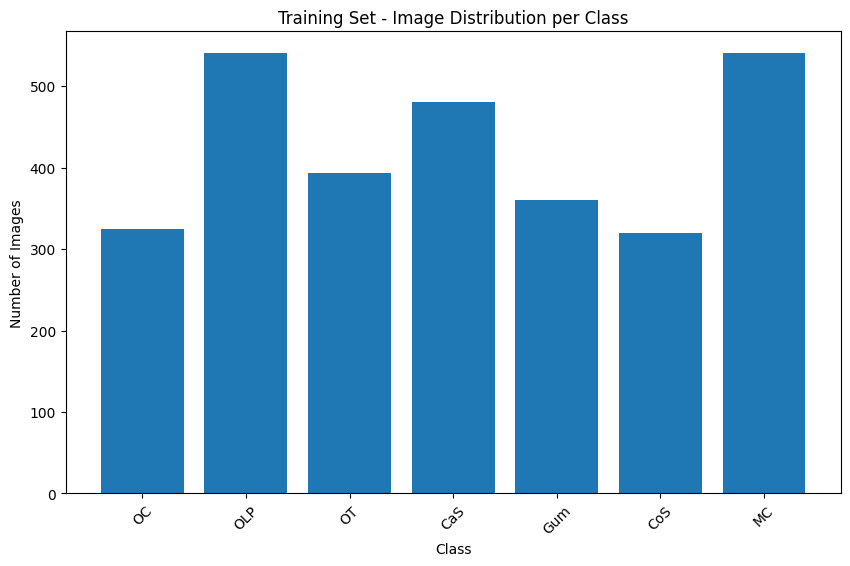

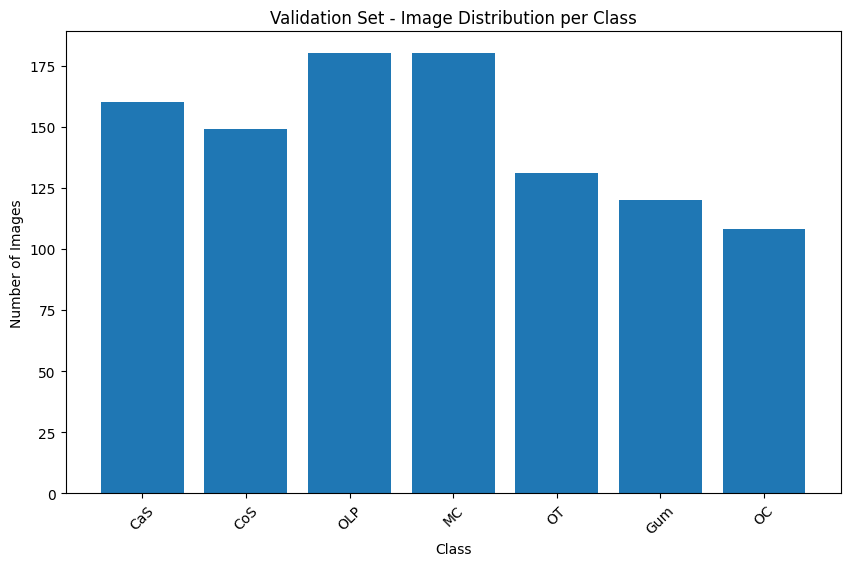

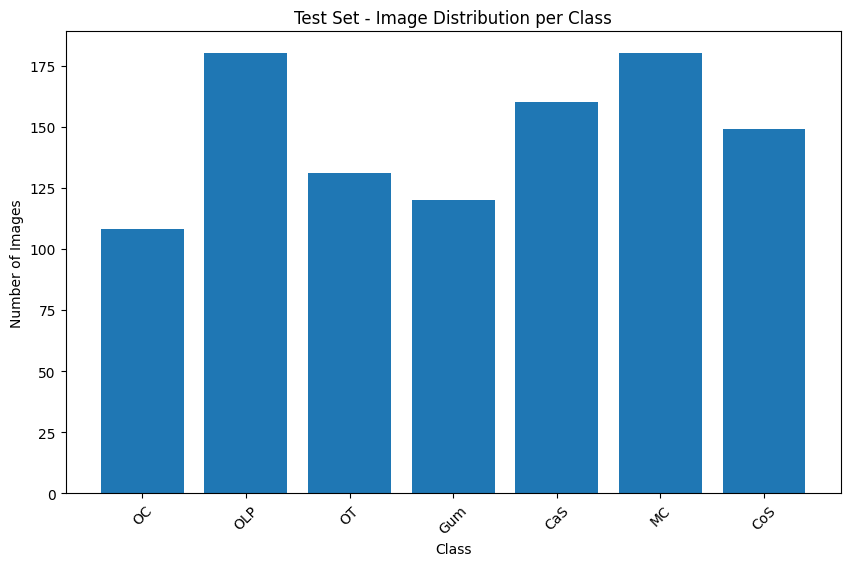

In [25]:
# Count images per class for each dataset split
train_class_counts = count_images_per_class(TRAIN_DIR)
validation_class_counts = count_images_per_class(VALIDATION_DIR)
test_class_counts = count_images_per_class(TEST_DIR)

# Visualize the counts for each split
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.title(f'{title} - Image Distribution per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Plot the class distributions
plot_class_distribution(train_class_counts, 'Training Set')
plot_class_distribution(validation_class_counts, 'Validation Set')
plot_class_distribution(test_class_counts, 'Test Set')

In [26]:
# Flow training images in batches using the generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Assuming multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2957 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


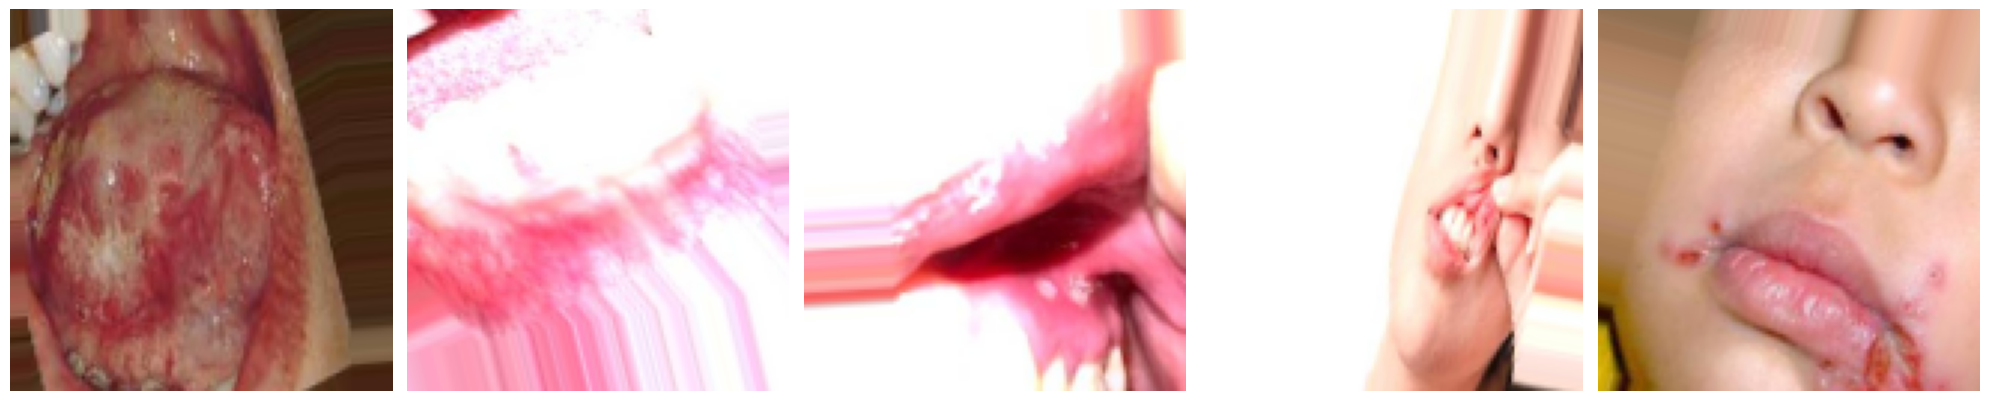

In [27]:
# 2. Visualizing the Dataset (Optional but Useful)

# Visualizing augmented images
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Display 5 sample images

In [28]:
# 3. Model Architecture (Custom CNN)

model = tf.keras.models.Sequential([
    # First Convolutional Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second Convolutional Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Third Convolutional Block
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flattening the layers
    tf.keras.layers.Flatten(),

    # Fully Connected Layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Regularization technique to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),

    # Output Layer (Assuming 3 classes for classification, update if different)
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

# 4. Compiling the Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',  # Adaptive optimizer
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# 5. Training the Model
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,005,383 (49.61 MB)

 Trainable params: 13,005,383 (49.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 580s 6s/step - accuracy: 0.1687 - loss: 2.0299 - val_accuracy: 0.1992 - val_loss: 1.8814
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1250 - loss: 1.8997 - val_accuracy: 0.2500 - val_loss: 2.2227
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.2444 - loss: 1.8337 - val_accuracy: 0.2256 - val_loss: 1.8378
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.1250 - loss: 1.8551 - val_accuracy: 0.0000e+00 - val_loss: 2.0211
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.2369 - loss: 1.8300 - val_accuracy: 0.3779 - val_loss: 1.6619
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.3750 - loss: 1.7113 - val_accuracy: 0.2500 - val_loss: 1.7104
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.2953 - loss: 1.7350 - val_accuracy: 0.3770 - val_loss: 1.5768
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.3125 - loss: 1.7397 - val_accuracy: 0.5000 - val_loss: 1.3779
Epoch 9/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3392 - loss: 1.6413 - val_accuracy: 0.4072 - val_loss: 1.6258
Epoch 10/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.4062 - loss: 1.6191 - val_accuracy: 0.2500 - val_l

32/32 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.7413 - loss: 0.8868
Test Accuracy: 71.97%


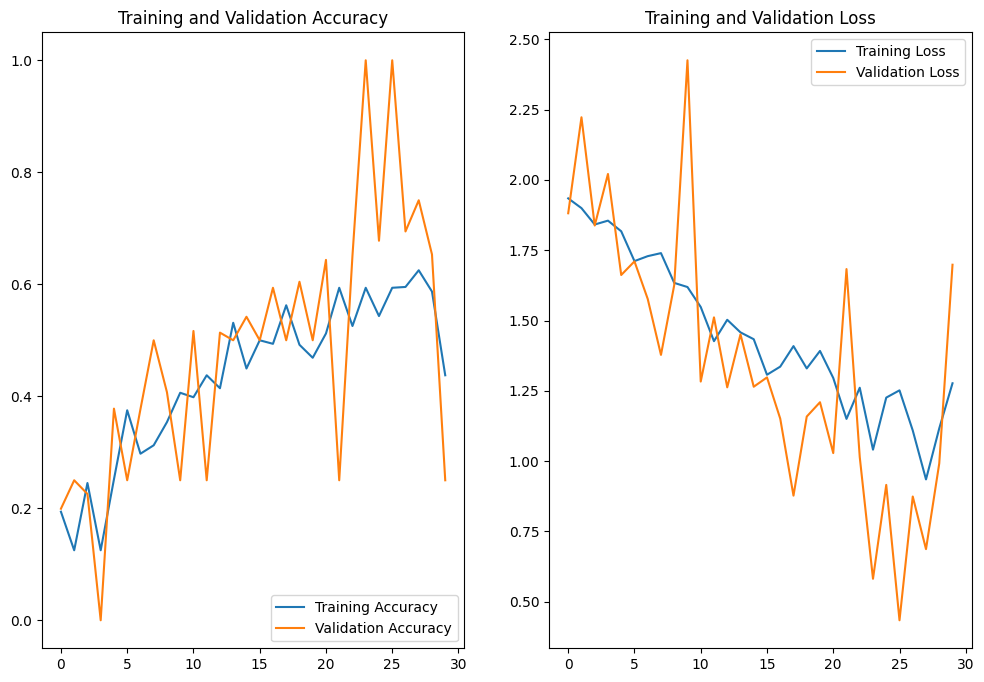

In [29]:
# 6. Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# 7. Plot training and validation performance
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)